In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from operator import attrgetter
from platform import python_version_tuple

xrange = range

import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import skimage
import skimage.measure
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import h5py
from tqdm import tqdm_notebook
from IPython.display import display
from extract_data import *
from skimage.transform import resize

In [3]:
h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'DRISHTI_GS.hdf5'), 'a')

### Exploring data

In [4]:
X_train, disc_train, cup_train, file_codes_train = extract_DRISHTI_GS_train(os.path.join(os.path.dirname(os.getcwd()), 'data', 'Drishti-GS'))
print(len(X_train), X_train[0].shape, len(disc_train), disc_train[0].shape, len(cup_train), cup_train[0].shape, len(file_codes_train))

50 (2040, 2040, 3) 50 (2040, 2040, 1) 50 (2040, 2040, 1) 50


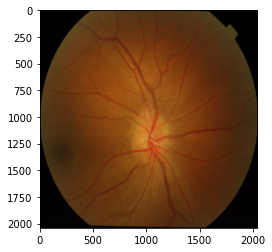

In [5]:
plt.imshow(X_train[49])

#### DRISHTI-GS (train)

In [6]:
resolution = get_resolution_DRISHTI_GS()
str_dt = h5py.special_dtype(vlen=str)

### Resizing Training Data

In [7]:
#resolutions = (512, 256, 128)
resolutions = 512
#for res in resolutions:
res = resolutions
h5f.create_group("DRISHTI-GS/{} px".format(res))

<HDF5 group "/DRISHTI-GS/512 px" (0 members)>

In [8]:
db = 'DRISHTI-GS'
X_ds =  np.array(X_train)
disc_ds = np.array(disc_train)
cup_ds = np.array(cup_train)
file_codes_ds = np.array(file_codes_train)

In [9]:
#for res in resolutions:
print('Copying data for {}, resolution {}'.format(db, res))
X_small_ds = h5f.create_dataset("{}/{} px/images".format(db, res), 
                                (X_ds.shape[0], res, res, 3,), 
                                chunks=(2, res, res, 3,), 
                                dtype=X_ds.dtype, compression="gzip")
disc_small_ds = h5f.create_dataset("{}/{} px/disc".format(db, res), 
                                   (X_ds.shape[0], res, res, 1,),  
                                   chunks=(2, res, res, 1,), 
                                   dtype=X_ds.dtype, compression="gzip")
str_dt = h5py.special_dtype(vlen=str_dt)
file_codes_small_ds = h5f.create_dataset("{}/{} px/file_codes".format(db, res), 
                                         (X_ds.shape[0],),  
                                         chunks=True, 
                                         dtype=str_dt, compression="gzip")
cup_small_ds = h5f.create_dataset("{}/{} px/cup".format(db, res), 
                              (X_ds.shape[0], res, res, 1,),  
                              chunks=(2, res, res, 1,), 
                              dtype=cup_ds.dtype, compression="gzip")

for i in tqdm_notebook(xrange(X_ds.shape[0]), leave=True):
    X_small_ds[i,:,:,:] = resize(X_ds[i], (res, res)) 
    
    cur_disc_small = resize(disc_ds[i][..., 0], (res, res))
    disc_small_ds[i,:,:] = cur_disc_small[..., np.newaxis]
    
    cur_cup_small =  resize(cup_ds[i][..., 0], (res, res))
    cup_small_ds[i] = cur_cup_small[..., np.newaxis]

Copying data for DRISHTI-GS, resolution 512


<ipython-input-9-452971e75a0a>:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(xrange(X_ds.shape[0]), leave=True):


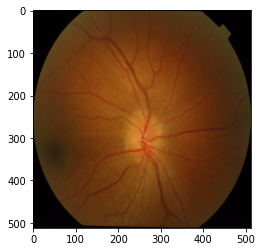

In [10]:
plt.imshow(h5f["DRISHTI-GS/512 px/images"][i])

In [11]:
gap = 70
standard_res = (512, 512)
X_ds = h5f["DRISHTI-GS/512 px/images"]
disc_ds_orig = h5f["DRISHTI-GS/512 px/disc"]
cup_ds_orig = h5f["DRISHTI-GS/512 px/cup"]

disc_locations = np.empty((X_ds.shape[0], 4), dtype=np.int64)

img_ds = h5f.create_dataset( 'DRISHTI-GS/512 px/img_cropped_70', 
                                (X_ds.shape[0], res, res, 3,), 
                                chunks=(2, res, res, 3,),
                                dtype=X_ds.dtype, compression="gzip")

disc_ds = h5f.create_dataset('DRISHTI-GS/512 px/disc_cropped_70', 
                                   (X_ds.shape[0], res, res, 1,),  
                                   chunks=(2, res, res, 1,),
                                   dtype=disc_ds_orig.dtype, compression="gzip")

cup_ds = h5f.create_dataset('DRISHTI-GS/512 px/cup_cropped_70', 
                                  (X_ds.shape[0], res, res, 1,),  
                                  chunks=(2, res, res, 1,), 
                                  dtype=cup_ds_orig.dtype, compression="gzip")

In [12]:
for i in tqdm_notebook(xrange(X_ds.shape[0]), leave=True):
    img = X_ds[i]
    disc = disc_ds_orig[i, ..., 0]
    cup = cup_ds_orig[i, ..., 0]

    labeled = skimage.measure.label(disc)
    region_props = skimage.measure.regionprops(labeled)
    component = max(region_props, key=attrgetter('area'))    # there should be only 1 component, 
                                                             # so this is a safety measure
    disc_locations[i][0] = max(component.bbox[0] - gap, 0)
    disc_locations[i][1] = max(component.bbox[1] - gap, 0)
    disc_locations[i][2] = min(component.bbox[2] + gap, img.shape[0] - 1)
    disc_locations[i][3] = min(component.bbox[3] + gap, img.shape[1] - 1)
    
    cup_cur_cropped = cup[disc_locations[i][0]:disc_locations[i][2],
                           disc_locations[i][1]:disc_locations[i][3]]
    cup_cur_cropped = resize(cup_cur_cropped, standard_res)    
    cup_ds[i, ..., 0] = cup_cur_cropped
    
    img_cur_cropped = img[disc_locations[i][0]:disc_locations[i][2],
                           disc_locations[i][1]:disc_locations[i][3]]
    img_cur_cropped = resize(img_cur_cropped, standard_res)
    img_ds[i] = img_cur_cropped
    
    disc_cur_cropped = disc[disc_locations[i][0]:disc_locations[i][2],
                           disc_locations[i][1]:disc_locations[i][3]]
    disc_cur_cropped = resize(disc_cur_cropped, standard_res)    
    disc_ds[i, ..., 0] = disc_cur_cropped

h5f['DRISHTI-GS/512 px/disc_locations_70'] = disc_locations

<ipython-input-12-e6689b467e77>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(xrange(X_ds.shape[0]), leave=True):


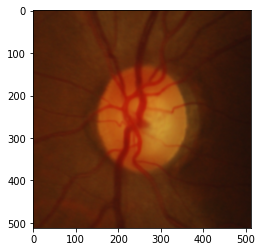

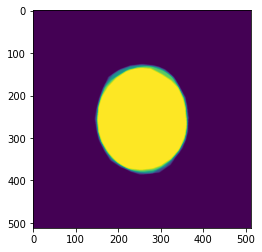

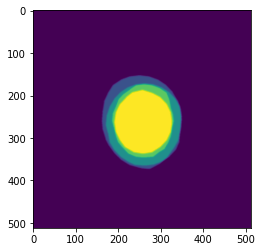

In [13]:
plt.imshow(h5f['DRISHTI-GS/512 px/img_cropped_70'][40]); plt.show()
plt.imshow(h5f['DRISHTI-GS/512 px/disc_cropped_70'][40]); plt.show()
plt.imshow(h5f['DRISHTI-GS/512 px/cup_cropped_70'][40]); plt.show()

In [14]:
gap = 30
disc_locations = np.empty((X_ds.shape[0], 4), dtype=np.int64)

img_ds = h5f.create_dataset( 'DRISHTI-GS/512 px/img_cropped_30', 
                                (X_ds.shape[0], res, res, 3,), 
                                chunks=(2, res, res, 3,),
                                dtype=X_ds.dtype, compression="gzip")

disc_ds = h5f.create_dataset('DRISHTI-GS/512 px/disc_cropped_30', 
                                   (X_ds.shape[0], res, res, 1,),  
                                   chunks=(2, res, res, 1,),
                                   dtype=disc_ds_orig.dtype, compression="gzip")

cup_ds = h5f.create_dataset('DRISHTI-GS/512 px/cup_cropped_30', 
                                  (X_ds.shape[0], res, res, 1,),  
                                  chunks=(2, res, res, 1,), 
                                  dtype=cup_ds_orig.dtype, compression="gzip")

for i in tqdm_notebook(xrange(X_ds.shape[0]), leave=True):
    img = X_ds[i]
    disc = disc_ds_orig[i, ..., 0]
    cup = cup_ds_orig[i, ..., 0]

    labeled = skimage.measure.label(disc)
    region_props = skimage.measure.regionprops(labeled)
    component = max(region_props, key=attrgetter('area'))    # there should be only 1 component, 
                                                             # so this is a safety measure
    disc_locations[i][0] = max(component.bbox[0] - gap, 0)
    disc_locations[i][1] = max(component.bbox[1] - gap, 0)
    disc_locations[i][2] = min(component.bbox[2] + gap, img.shape[0] - 1)
    disc_locations[i][3] = min(component.bbox[3] + gap, img.shape[1] - 1)
    
    cup_cur_cropped = cup[disc_locations[i][0]:disc_locations[i][2],
                           disc_locations[i][1]:disc_locations[i][3]]
    cup_cur_cropped = resize(cup_cur_cropped, standard_res)    
    cup_ds[i, ..., 0] = cup_cur_cropped
    
    img_cur_cropped = img[disc_locations[i][0]:disc_locations[i][2],
                           disc_locations[i][1]:disc_locations[i][3]]
    img_cur_cropped = resize(img_cur_cropped, standard_res)
    img_ds[i] = img_cur_cropped
    
    disc_cur_cropped = disc[disc_locations[i][0]:disc_locations[i][2],
                           disc_locations[i][1]:disc_locations[i][3]]
    disc_cur_cropped = resize(disc_cur_cropped, standard_res)    
    disc_ds[i, ..., 0] = disc_cur_cropped
    
h5f['DRISHTI-GS/512 px/disc_locations_30'] = disc_locations

<ipython-input-14-e5b082e2109e>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(xrange(X_ds.shape[0]), leave=True):


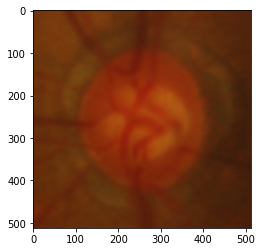

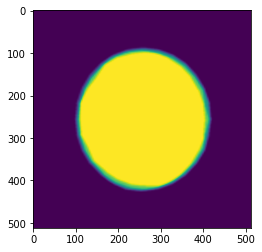

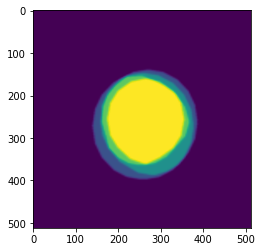

In [15]:
plt.imshow(h5f['DRISHTI-GS/512 px/img_cropped_30'][9]); plt.show()
plt.imshow(h5f['DRISHTI-GS/512 px/disc_cropped_30'][9]); plt.show()
plt.imshow(h5f['DRISHTI-GS/512 px/cup_cropped_30'][9]); plt.show()

#### DRISHTI-GS (test)

In [16]:
X_test, disc_test, cup_test, file_codes_test = extract_DRISHTI_GS_test(os.path.join(os.path.dirname(os.getcwd()), 'data', 'Drishti-GS'))
print(len(X_test), X_test[0].shape, len(disc_test), disc_test[0].shape, len(cup_test), cup_test[0].shape, len(file_codes_test))

51 (2040, 2040, 3) 51 (2040, 2040, 1) 51 (2040, 2040, 1) 51


In [17]:
db = 'DRISHTI-GS-test'
X_ds = np.array(X_test)
disc_ds = np.array(disc_test)
cup_ds = np.array(cup_test)
file_codes_ds = np.array(file_codes_test)

#for res in resolutions:
print('Copying data for {}, resolution {}'.format(db, res))
X_small_ds = h5f.create_dataset("{}/{} px/images".format(db, res), 
                                (X_ds.shape[0], res, res, 3,), 
                                chunks=(2, res, res, 3,), 
                                dtype=X_ds.dtype, compression="gzip")

str_dt = h5py.special_dtype(vlen=str)
file_codes_small_ds = h5f.create_dataset("{}/{} px/file_codes".format(db, res), 
                                         (X_ds.shape[0],),  
                                         chunks=True, 
                                         dtype=str_dt, compression="gzip")

disc_small_ds = h5f.create_dataset("{}/{} px/disc".format(db, res), 
                                   (X_ds.shape[0], res, res, 1,),  
                                   chunks=(2, res, res, 1,), 
                                   dtype=disc_ds.dtype, compression="gzip")

cup_small_ds = h5f.create_dataset("{}/{} px/cup".format(db, res), 
                                  (X_ds.shape[0], res, res, 1,),  
                                  chunks=(2, res, res, 1,), 
                                  dtype=cup_ds.dtype, compression="gzip")

for i in tqdm_notebook(xrange(X_ds.shape[0]), leave=True):
    X_small_ds[i] = resize(X_ds[i],(res, res))
    
    cur_disc_small = resize(disc_ds[i][..., 0], (res, res))
    disc_small_ds[i] = cur_disc_small[..., np.newaxis]  
    
    cur_cup_small = resize(cup_ds[i][..., 0], (res, res))
    cup_small_ds[i] = cur_cup_small[..., np.newaxis]
    
file_codes_small_ds[:] = file_codes_ds[:]  

Copying data for DRISHTI-GS-test, resolution 512


<ipython-input-17-9683e8e7fc9b>:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(xrange(X_ds.shape[0]), leave=True):


In [18]:
X_ds = h5f["DRISHTI-GS-test/512 px/images"]
disc_ds_orig = h5f["DRISHTI-GS-test/512 px/disc"]
cup_ds_orig = h5f["DRISHTI-GS-test/512 px/cup"]

gap = 70
standard_res = (512, 512)

disc_locations = np.empty((X_ds.shape[0], 4), dtype=np.int64)

img_ds = h5f.create_dataset( 'DRISHTI-GS-test/512 px/img_cropped_70', 
                                (X_ds.shape[0], res, res, 3,), 
                                chunks=(2, res, res, 3,),
                                dtype=X_ds.dtype, compression="gzip")

disc_ds = h5f.create_dataset('DRISHTI-GS-test/512 px/disc_cropped_70', 
                                   (X_ds.shape[0], res, res, 1,),  
                                   chunks=(2, res, res, 1,),
                                   dtype=disc_ds_orig.dtype, compression="gzip")

cup_ds = h5f.create_dataset('DRISHTI-GS-test/512 px/cup_cropped_70', 
                                  (X_ds.shape[0], res, res, 1,),  
                                  chunks=(2, res, res, 1,), 
                                  dtype=cup_ds_orig.dtype, compression="gzip")

for i in tqdm_notebook(xrange(X_ds.shape[0]), leave=True):
    img = X_ds[i]
    disc = disc_ds_orig[i, ..., 0]
    cup = cup_ds_orig[i, ..., 0]

    labeled = skimage.measure.label(disc)
    region_props = skimage.measure.regionprops(labeled)
    component = max(region_props, key=attrgetter('area'))    # there should be only 1 component, 
                                                             # so this is a safety measure
    disc_locations[i][0] = max(component.bbox[0] - gap, 0)
    disc_locations[i][1] = max(component.bbox[1] - gap, 0)
    disc_locations[i][2] = min(component.bbox[2] + gap, img.shape[0] - 1)
    disc_locations[i][3] = min(component.bbox[3] + gap, img.shape[1] - 1)
    
    cup_cur_cropped = cup[disc_locations[i][0]:disc_locations[i][2],
                           disc_locations[i][1]:disc_locations[i][3]]
    cup_cur_cropped = resize(cup_cur_cropped, standard_res)    
    cup_ds[i, ..., 0] = cup_cur_cropped
    
    img_cur_cropped = img[disc_locations[i][0]:disc_locations[i][2],
                           disc_locations[i][1]:disc_locations[i][3]]
    img_cur_cropped = resize(img_cur_cropped, standard_res)
    img_ds[i] = img_cur_cropped
    
    disc_cur_cropped = disc[disc_locations[i][0]:disc_locations[i][2],
                           disc_locations[i][1]:disc_locations[i][3]]
    disc_cur_cropped = resize(disc_cur_cropped, standard_res)    
    disc_ds[i, ..., 0] = disc_cur_cropped

h5f['DRISHTI-GS-test/512 px/disc_locations_70'] = disc_locations

<ipython-input-18-9b0a2f136fd8>:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(xrange(X_ds.shape[0]), leave=True):


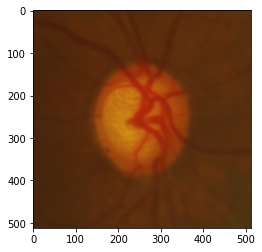

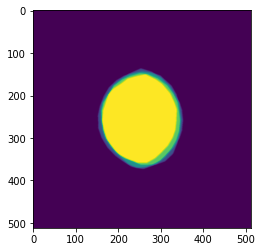

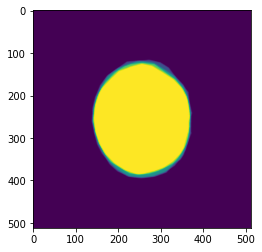

In [19]:
plt.imshow(h5f['DRISHTI-GS-test/512 px/img_cropped_70'][0]); plt.show()
plt.imshow(h5f['DRISHTI-GS-test/512 px/cup_cropped_70'][0]); plt.show()
plt.imshow(h5f['DRISHTI-GS-test/512 px/disc_cropped_70'][0]); plt.show()

In [20]:
gap = 30
standard_res = (512, 512)

disc_locations = np.empty((X_ds.shape[0], 4), dtype=np.int64)

img_ds = h5f.create_dataset( 'DRISHTI-GS-test/512 px/img_cropped_30', 
                                (X_ds.shape[0], res, res, 3,), 
                                chunks=(2, res, res, 3,),
                                dtype=X_ds.dtype, compression="gzip")

disc_ds = h5f.create_dataset('DRISHTI-GS-test/512 px/disc_cropped_30', 
                                   (X_ds.shape[0], res, res, 1,),  
                                   chunks=(2, res, res, 1,),
                                   dtype=disc_ds_orig.dtype, compression="gzip")

cup_ds = h5f.create_dataset('DRISHTI-GS-test/512 px/cup_cropped_30', 
                                  (X_ds.shape[0], res, res, 1,),  
                                  chunks=(2, res, res, 1,), 
                                  dtype=cup_ds_orig.dtype, compression="gzip")

for i in tqdm_notebook(xrange(X_ds.shape[0]), leave=True):
    img = X_ds[i]
    disc = disc_ds_orig[i, ..., 0]
    cup = cup_ds_orig[i, ..., 0]

    labeled = skimage.measure.label(disc)
    region_props = skimage.measure.regionprops(labeled)
    component = max(region_props, key=attrgetter('area'))    # there should be only 1 component, 
                                                             # so this is a safety measure
    disc_locations[i][0] = max(component.bbox[0] - gap, 0)
    disc_locations[i][1] = max(component.bbox[1] - gap, 0)
    disc_locations[i][2] = min(component.bbox[2] + gap, img.shape[0] - 1)
    disc_locations[i][3] = min(component.bbox[3] + gap, img.shape[1] - 1)
    
    cup_cur_cropped = cup[disc_locations[i][0]:disc_locations[i][2],
                           disc_locations[i][1]:disc_locations[i][3]]
    cup_cur_cropped = resize(cup_cur_cropped, standard_res)    
    cup_ds[i, ..., 0] = cup_cur_cropped
    
    img_cur_cropped = img[disc_locations[i][0]:disc_locations[i][2],
                           disc_locations[i][1]:disc_locations[i][3]]
    img_cur_cropped = resize(img_cur_cropped, standard_res)
    img_ds[i] = img_cur_cropped
    
    disc_cur_cropped = disc[disc_locations[i][0]:disc_locations[i][2],
                           disc_locations[i][1]:disc_locations[i][3]]
    disc_cur_cropped = resize(disc_cur_cropped, standard_res)    
    disc_ds[i, ..., 0] = disc_cur_cropped

h5f['DRISHTI-GS-test/512 px/disc_locations_30'] = disc_locations

<ipython-input-20-2d06c2aeeb31>:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(xrange(X_ds.shape[0]), leave=True):


In [21]:
h5f.close()